In [81]:
import pandas as pd
import numpy as np
import json

import re
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from bs4 import BeautifulSoup

import coursera_model as cm
from coursera_model import tokenize_text

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np

tfidf_mat = pickle.load(open("./data/coursera/tfidf_mat.pkl", "rb" ))
c_course_list = pickle.load(open("./data/coursera/course_list.pkl", "rb" ))
vectorizer = pickle.load(open("./data/coursera/vectorizer.pkl", "rb" ))

c_tfidf_mat = tfidf_mat[:len(c_course_list), :]

In [14]:
# coursera --------------------
with open('./data/coursera/coursera_courses.json') as c_file:
    coursera_courses = json.load(c_file)
    course_list = coursera_courses['elements']
    
coursera = coursera_courses
cat_dict = coursera['linked']
coursera = coursera['elements']

In [13]:
print len(coursera)

916


In [19]:
coursera[0].keys()
has_links = 0
no_link_index = []
for i, course in enumerate(coursera):
    if course['links']:
        has_links += 1
    else:
        no_link_index.append(i)
print has_links
print len(no_link_index)

909
7


In [20]:
print no_link_index # [181, 308, 349, 499, 688, 737, 854]
coursera[181] # linear programming, math

[181, 308, 349, 499, 688, 737, 854]


{u'aboutTheCourse': u'<div><p>Linear Programming (LP) is arguably one of the most important optimization problems in applied mathematics and engineering. The Simplex algorithm to solve linear programs is widely regarded as one among the "<a href="http://www.siam.org/pdf/news/637.pdf">top ten</a>"&nbsp;algorithms of the 20th century. Linear Programs arise in almost all fields of engineering including operations research, statistics, machine learning, control system design, scheduling, formal verification&nbsp;and computer vision. It forms the basis for numerous approaches to solving hard combinatorial optimization problems through randomization and approximation.</p><p><br></p><p>The primary goals of this course&nbsp;will be to:</p><p>1. Understand the basic theory behind LP, algorithms to solve LPs, and the basics of (mixed) integer programs (ILP).</p><p>2. Understand important and emerging applications of LP and ILPs to economic problems (optimal resource allocation, scheduling proble

In [23]:
tfidf_mat = pickle.load(open("./data/coursera/tfidf_mat.pkl", "rb" ))
c_course_list = pickle.load(open("./data/coursera/course_list.pkl", "rb" ))
vectorizer = pickle.load(open("./data/coursera/vectorizer.pkl", "rb" ))

c_tfidf_mat = tfidf_mat[:len(c_course_list), :]

In [24]:
from sklearn.cluster import KMeans

In [34]:
km = KMeans(random_state=10)
km.fit(c_tfidf_mat.T)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=10, tol=0.0001,
    verbose=0)

In [35]:
km.cluster_centers_

array([[  3.41142978e-04,   1.89858804e-04,   2.79017155e-04, ...,
          2.73997616e-04,   2.84538942e-04,   1.77754324e-04],
       [  0.00000000e+00,   5.21842245e-02,   1.56377699e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.11976594e-01,   4.82682428e-02,   8.28409243e-01, ...,
          5.34503067e-01,   4.63981817e-01,   4.74430892e-01],
       ..., 
       [  7.84282202e-02,   0.00000000e+00,   0.00000000e+00, ...,
          1.16989081e-01,   2.11938321e-01,   7.04311613e-01],
       [  1.83516656e-02,   1.13631716e-01,   5.62115463e-02, ...,
          3.96984482e-02,   9.15080389e-02,   3.45952027e-02],
       [  0.00000000e+00,   0.00000000e+00,   1.23933386e-01, ...,
          1.86582267e-01,   4.22517344e-02,   1.72813048e-01]])

In [46]:
from sklearn.decomposition import TruncatedSVD
print tfidf_mat.shape

(3983, 22155)


ValueError: 0.9 is not in list

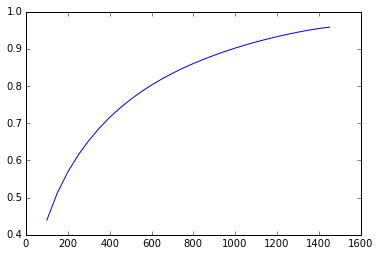

In [149]:
n_dims = range(100, 1500, 50)

svd = TruncatedSVD(n_components=max(n_dims), random_state=10)
svd.fit(tfidf_mat)

explained_var = [np.sum(svd.explained_variance_ratio_[:x]) for x in n_dims]


plt.plot(n_dims, explained_var)

In [160]:
print explained_var[6] # 400 dim, 70% var
print explained_var[10] # 600 dim, 80% var
print explained_var[18] # 1000 dim, 90% var

0.715569678061
0.802515330503
0.901940300298


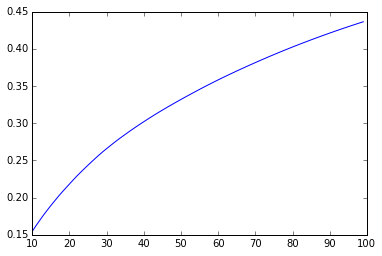

In [80]:
n_dims = range(10, 100)

svd = TruncatedSVD(n_components=max(n_dims), random_state=10)
svd.fit(tfidf_mat)

explained_var = [np.sum(svd.explained_variance_ratio_[:x]) for x in n_dims]


plt.plot(n_dims, explained_var)

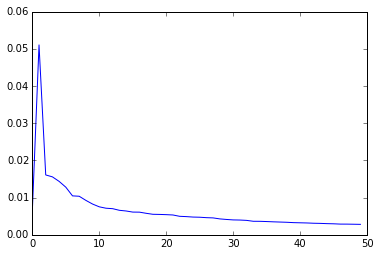

In [76]:
plt.plot(svd.explained_variance_ratio_[:50])

In [165]:
svd = TruncatedSVD(n_components=1000, random_state=10) 
# 400 dim, 70% var
# 600 dim, 80% var
# 1000 dim, 90% var
red_tfidf_mat = svd.fit_transform(tfidf_mat)
c_red_tfidf_mat = red_tfidf_mat[:len(c_course_list), :]

In [83]:
"""collect github job descriptions and titles"""
git_data = json.load(open('./data/github/github_postings'))
git_jobs_titles = []
git_jobs_descriptions = []

for job in git_data:
    git_jobs_titles.append(job['title'])
    git_jobs_descriptions.append(BeautifulSoup(job['description']).text)

In [89]:
def build_recommend_table(input_text, lsa_mat, vectorizer, course_list, lsa, n=5):
    indices = get_n_most_similar_indices_lsa(input_text, lsa_mat, vectorizer, lsa, n=n)
    header = ['Course Name', 'Course Description']
    table = [header]
    for i in indices:
        course = course_list[i]
        name = course['name']
        short_desc = course['shortDescription']
        url = 'https://www.coursera.org/course/' + course['shortName']
        table.append([name, short_desc, url])
    return table

In [216]:
input_index = np.random.randint(len(git_jobs_descriptions))
input_text = git_jobs_descriptions[input_index]
old_table = cm.build_recommend_table(input_text, c_tfidf_mat, vectorizer, c_course_list, n=5)

In [217]:
n = 5
input_tfidf = vectorizer.transform([input_text])
input_lsa = svd.transform(input_tfidf)
cos_sims = c_red_tfidf_mat.dot(input_lsa.T) #vects already have unit norm
top_n_indices = np.argsort(cos_sims, axis=0)[-1:-(n + 1):-1, 0]
print top_n_indices.tolist()

[95, 809, 885, 869, 36]


In [218]:
print git_jobs_titles[input_index]
print 'old'
for x in xrange(1, n+1):
    print old_table[x][0]
print

for i in [400, 600, 1000]:
    n = 5
    input_tfidf = vectorizer.transform([input_text])
    input_lsa = svd.transform(input_tfidf)[:, :i]
    cos_sims = c_red_tfidf_mat[:, :i].dot(input_lsa.T) #vects already have unit norm
    top_n_indices = np.argsort(cos_sims, axis=0)[-1:-(n + 1):-1, 0]

    indices = top_n_indices.tolist()
    header = ['Course Name', 'Course Description']
    table = [header]
    for ind in indices:
        course = course_list[ind]
        name = course['name']
        short_desc = course['shortDescription']
        url = 'https://www.coursera.org/course/' + course['shortName']
        table.append([name, short_desc, url])
        
    print git_jobs_titles[input_index]
    print 'SVD of %s' % (i)
    for x in xrange(1, n+1):
        print table[x][0]
    print 

iOS Engineer
old
Design Thinking for Business Innovation
Leading Innovation in Arts and Culture
Designing, Running, and Analyzing Experiments
Creating Site-Specific Dance and Performance Works
Programming Mobile Applications for Android Handheld Systems: Part 2

iOS Engineer
SVD of 400
Design Thinking for Business Innovation
Programming Mobile Applications for Android Handheld Systems: Part 1
Programming Mobile Services for Android Handheld Systems: Communication
Designing, Running, and Analyzing Experiments
Programming Mobile Applications for Android Handheld Systems: Part 2

iOS Engineer
SVD of 600
Design Thinking for Business Innovation
Programming Mobile Applications for Android Handheld Systems: Part 1
Programming Mobile Applications for Android Handheld Systems: Part 2
Leading Innovation in Arts and Culture
Creative, Serious and Playful Science of Android Apps

iOS Engineer
SVD of 1000
Design Thinking for Business Innovation
Powerful Tools for Teaching and Learning: Web 2.0 Tools

In [205]:
print git_jobs_titles[input_index]
print 'new', "|", 'old'
for x in xrange(1, n+1):
    print table[x][0], "|", old_table[x][0]

Back-End Engineer
new | old
Design Thinking for Business Innovation | Design Thinking for Business Innovation
An Introduction to Interactive Programming in Python | An Introduction to Interactive Programming in Python (Part 2)
An Introduction to Interactive Programming in Python (Part 2) | An Introduction to Interactive Programming in Python
An Introduction to Interactive Programming in Python (Part 1) | An Introduction to Interactive Programming in Python (Part 1)
E-learning and Digital Cultures | E-learning and Digital Cultures


In [206]:
old_table

[['Course Name', 'Course Description'],
 [u'Design Thinking for Business Innovation',
  u'This course provides an overview of the Design Thinking process and tools used for business innovation.\n\n',
  u'https://www.coursera.org/course/designbiz'],
 [u'An Introduction to Interactive Programming in Python (Part 2)',
  u'This two-part course is designed to be a fun introduction to the basics of programming in Python. Our main focus will be on building simple interactive games such as Pong, Blackjack and Asteroids.',
  u'https://www.coursera.org/course/interactivepython2'],
 [u'An Introduction to Interactive Programming in Python',
  u'This course is designed to be a fun introduction to the basics of programming in Python. Our main focus will be on building simple interactive games such as Pong, Blackjack and Asteroids.',
  u'https://www.coursera.org/course/interactivepython'],
 [u'An Introduction to Interactive Programming in Python (Part 1)',
  u'This two-part course is designed to be a

In [223]:
len(cat_dict['categories'])

25